In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier  # NEW

# -------------------------------------------------------------------
# FILE PATHS 
# -------------------------------------------------------------------
TRAIN_DATA_PATH = "PhysioData/training/training_setB"
TEST_DATA_PATH  = "PhysioData/training/training_setA" 

# -------------------------------------------------------------------
# Load a single .psv file
# -------------------------------------------------------------------
def load_psv(file_path):
    return pd.read_csv(file_path, sep='|')

# -------------------------------------------------------------------
# Clean a patient dataframe
# -------------------------------------------------------------------
def clean_patient_df(df):
    df = df.dropna(how='all')       # remove empty rows
    df = df.replace(-1, np.nan)     # treat -1 as missing
    df = df.ffill().bfill()         # forward/back fill
    df = df.fillna(df.median())     # last fallback
    return df

# -------------------------------------------------------------------
# Convert 1 patient → 1-row feature vector
# -------------------------------------------------------------------
def extract_features(df):
    features = {}
    numeric_cols = [
        c for c in df.columns
        if c != "SepsisLabel" and np.issubdtype(df[c].dtype, np.number)
    ]

    for col in numeric_cols:
        features[col + "_mean"] = df[col].mean()
        features[col + "_std"]  = df[col].std()
        features[col + "_min"]  = df[col].min()
        features[col + "_max"]  = df[col].max()
    
    return features

# -------------------------------------------------------------------
# LOAD A FRACTION OF TEST FILES
# -------------------------------------------------------------------
def list_test_subset(test_folder, fraction=0.20, seed=42):
    random.seed(seed)
    all_files = [os.path.join(test_folder, f)
                 for f in os.listdir(test_folder)
                 if f.endswith(".psv")]

    subset_size = max(1, int(len(all_files) * fraction))
    return random.sample(all_files, subset_size)

# Same loader as load_patient_folder, but accepts a list of paths
def load_patient_list(file_paths):
    rows = []
    for full in file_paths:
        try:
            df = load_psv(full)
            df = clean_patient_df(df)
            feats = extract_features(df)
            feats["SepsisLabel"] = int(df["SepsisLabel"].max())
            rows.append(feats)
        except Exception as e:
            print("Error loading:", full, e)

    data = pd.DataFrame(rows)
    data = data.dropna(axis=1, how='all')
    return data

# -------------------------------------------------------------------
# Full folder loader - for training
# -------------------------------------------------------------------
def load_patient_folder(folder_path):
    rows = []
    for fname in os.listdir(folder_path):
        if fname.endswith(".psv"):
            full = os.path.join(folder_path, fname)
            try:
                df = load_psv(full)
                df = clean_patient_df(df)
                feats = extract_features(df)
                feats["SepsisLabel"] = int(df["SepsisLabel"].max())
                rows.append(feats)
            except Exception as e:
                print("Error loading file:", fname, e)

    data = pd.DataFrame(rows)
    data = data.dropna(axis=1, how='all')
    return data

# -------------------------------------------------------------------
# LOAD TRAIN + TEST DATA
# -------------------------------------------------------------------
print("Loading TRAIN DATA")
train_data = load_patient_folder(TRAIN_DATA_PATH)
print("Train shape:", train_data.shape)

print("\nSampling TEST DATA")
subset_paths = list_test_subset(TEST_DATA_PATH, fraction=0.20, seed=42)
test_data = load_patient_list(subset_paths)
print("Sampled test shape:", test_data.shape)

# -------------------------------------------------------------------
# ALIGN FEATURES (CRITICAL)
# -------------------------------------------------------------------
train_cols = set(train_data.columns)
test_cols  = set(test_data.columns)

missing_in_test = train_cols - test_cols - {"SepsisLabel"}
extra_in_test   = test_cols - train_cols - {"SepsisLabel"}

for col in missing_in_test:
    test_data[col] = train_data[col].median()

for col in extra_in_test:
    test_data = test_data.drop(columns=[col])

test_data = test_data[train_data.columns]



Loading TRAIN DATA
Train shape: (20000, 161)

Sampling TEST DATA
Sampled test shape: (4067, 157)



Training Random Forest...

--- Random Forest Threshold Sweep ---
Threshold=0.05  Sensitivity=0.772  Accuracy=0.774
Threshold=0.10  Sensitivity=0.590  Accuracy=0.912
Threshold=0.15  Sensitivity=0.494  Accuracy=0.939
Threshold=0.20  Sensitivity=0.438  Accuracy=0.946
Threshold=0.25  Sensitivity=0.383  Accuracy=0.945
Threshold=0.30  Sensitivity=0.330  Accuracy=0.943
Threshold=0.35  Sensitivity=0.281  Accuracy=0.940
Threshold=0.40  Sensitivity=0.228  Accuracy=0.938
Threshold=0.45  Sensitivity=0.154  Accuracy=0.932
Threshold=0.50  Sensitivity=0.130  Accuracy=0.930

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3743
           1       0.83      0.38      0.52       324

    accuracy                           0.94      4067
   macro avg       0.89      0.69      0.75      4067
weighted avg       0.94      0.94      0.94      4067

RF Accuracy: 0.9446766658470617
RF Sensitivity: 0.382716049382

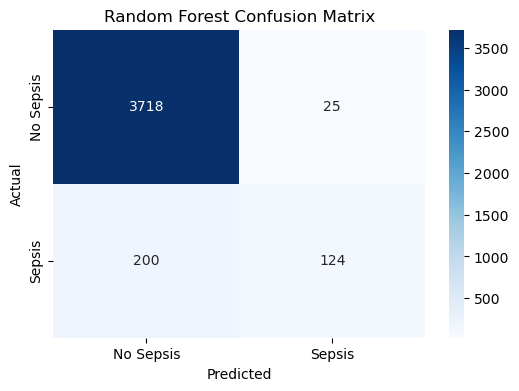


Training XGBoost...

--- XGBoost Threshold Sweep ---
Threshold=0.05  Sensitivity=0.778  Accuracy=0.801
Threshold=0.10  Sensitivity=0.738  Accuracy=0.869
Threshold=0.15  Sensitivity=0.688  Accuracy=0.894
Threshold=0.20  Sensitivity=0.654  Accuracy=0.908
Threshold=0.25  Sensitivity=0.627  Accuracy=0.921
Threshold=0.30  Sensitivity=0.599  Accuracy=0.928
Threshold=0.35  Sensitivity=0.580  Accuracy=0.933
Threshold=0.40  Sensitivity=0.568  Accuracy=0.937
Threshold=0.45  Sensitivity=0.556  Accuracy=0.940
Threshold=0.50  Sensitivity=0.543  Accuracy=0.943

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3743
           1       0.50      0.63      0.56       324

    accuracy                           0.92      4067
   macro avg       0.74      0.79      0.76      4067
weighted avg       0.93      0.92      0.92      4067

XGBoost Accuracy: 0.9210720432751414
XGBoost Sensitivity: 0.6265432098765432


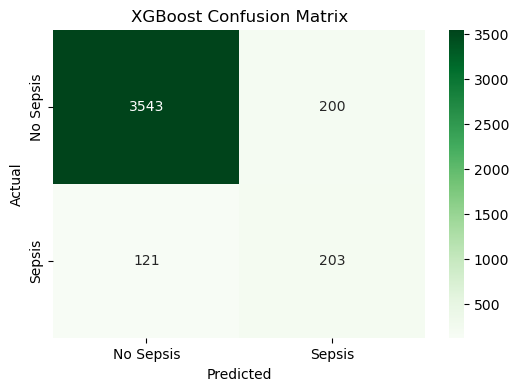

In [2]:

# -------------------------------------------------------------------
# MODEL TRAINING
# -------------------------------------------------------------------
X_train = train_data.drop("SepsisLabel", axis=1)
y_train = train_data["SepsisLabel"]

X_test  = test_data.drop("SepsisLabel", axis=1)
y_test  = test_data["SepsisLabel"]

# ================================================================
# RANDOM FOREST MODEL
# ================================================================
rf = RandomForestClassifier(
    n_estimators=2000,
    max_depth=None,
    class_weight={0:1, 1:100},
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest...")
rf.fit(X_train, y_train)

# RF INFERENCE
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\n--- Random Forest Threshold Sweep ---")
thresholds = np.linspace(0.05, 0.50, 10)

for t in thresholds:
    y_pred_t = (y_prob_rf > t).astype(int)
    TP = ((y_test == 1) & (y_pred_t == 1)).sum()
    FN = ((y_test == 1) & (y_pred_t == 0)).sum()
    sensitivity = TP / (TP + FN)
    accuracy = (y_test == y_pred_t).mean()
    print(f"Threshold={t:.2f}  Sensitivity={sensitivity:.3f}  Accuracy={accuracy:.3f}")

y_pred_rf = (y_prob_rf > 0.25).astype(int)

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
TP = cm_rf[1, 1]
FN = cm_rf[1, 0]
sensitivity_rf = TP / (TP + FN)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Sensitivity:", sensitivity_rf)

# RF Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Sepsis', 'Sepsis'],
            yticklabels=['No Sepsis', 'Sepsis'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ================================================================
# XGBOOST MODEL
# ================================================================
print("\nTraining XGBoost...")

xgb = XGBClassifier(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

# XGB INFERENCE
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n--- XGBoost Threshold Sweep ---")
for t in thresholds:
    y_pred_t = (y_prob_xgb > t).astype(int)
    TP = ((y_test == 1) & (y_pred_t == 1)).sum()
    FN = ((y_test == 1) & (y_pred_t == 0)).sum()
    sensitivity = TP / (TP + FN)
    accuracy = (y_test == y_pred_t).mean()
    print(f"Threshold={t:.2f}  Sensitivity={sensitivity:.3f}  Accuracy={accuracy:.3f}")

y_pred_xgb = (y_prob_xgb > 0.25).astype(int)

print("\n--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
TP = cm_xgb[1, 1]
FN = cm_xgb[1, 0]
sensitivity_xgb = TP / (TP + FN)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Sensitivity:", sensitivity_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Sepsis', 'Sepsis'],
            yticklabels=['No Sepsis', 'Sepsis'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()